In [1]:
# for running in collab, sagemaker etc.
import sys
sys.path.insert(0, "/home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils")

In [2]:
import wandb

In [3]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2023-04-25 09:30:04.121379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 09:30:04.315902: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-25 09:30:04.315962: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-25 09:30:05.164128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

[]


2023-04-25 09:30:06.251194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-25 09:30:06.251238: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-25 09:30:06.251262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.11.0


In [5]:
SAVE_EXPERIMENT_DATA = True

### Load and process data

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [7]:
data = pd.read_pickle('../../data/data_proton_photonsum_15_2133.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

# Data containing particle conditional data from particle having responses with proton photon sum in interval [70, 2312] without taking into consideration photon sums of neutron responses.
data_cond = pd.read_pickle('../../data/data_cond_stddev_photonsum_15_2133_15_3273.pkl')
print('Loaded cond: ',  data_cond.shape, "max:", data_cond.values.max(), "min:", data_cond.values.min())

Loaded:  (48714, 56, 30) max: 678.0
Loaded cond:  (48714, 13) max: 7000.0 min: -7000.0


In [8]:
# calculate min max proton sum
photon_sum_proton_min, photon_sum_proton_max = data_cond.proton_photon_sum.min(), data_cond.proton_photon_sum.max()

In [9]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum', 'group_number'], inplace=True)
data_cond.columns, len(data_cond.columns)

(Index(['Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge', 'std'], dtype='object'),
 10)

In [10]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0,0.076311
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.479201
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.090233
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.131331
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.103628


In [11]:
STRENGTH = 0.1

DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "sdi-gan"

wandb_run_name = f"{int(photon_sum_proton_min)}_{int(photon_sum_proton_max)}_{DATE_STR}"

EXPERIMENT_DIR_NAME = f"experiments/{NAME}_{int(photon_sum_proton_min)}_{int(photon_sum_proton_max)}_{DATE_STR}"

print("Experiment DIR: ", EXPERIMENT_DIR_NAME)

Experiment DIR:  experiments/sdi-gan_15_2133_25_04_2023_09_30


In [12]:
def create_dir(path):
    if SAVE_EXPERIMENT_DATA:
        isExist = os.path.exists(path)
        if not isExist:
            os.makedirs(path)

In [13]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)

    if SAVE_EXPERIMENT_DATA:
        filepath = f"../../{EXPERIMENT_DIR_NAME}/scales/"
        create_dir(filepath)
        with open(filepath+out_fnm, mode="w") as f:
            f.write(res)

In [14]:
data_cond["cond"] = data_cond["Energy"].astype(str) +"|"+ data_cond["Vx"].astype(str) +"|"+  data_cond["Vy"].astype(str) +"|"+ data_cond["Vz"].astype(str) +"|"+  data_cond["Px"].astype(str) +"|"+  data_cond["Py"].astype(str) +"|"+ data_cond["Pz"].astype(str) +"|"+  data_cond["mass"].astype(str) +"|"+  data_cond["charge"].astype(str)
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std,cond
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0,0.076311,3192.38|0.0|0.0|0.0|0.022422400000000002|-0.18...
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.479201,3961.55|0.0|0.0|0.0|-0.0764874|0.179845|3961.5...
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.090233,2770.1|1.86117e-17|2.5171900000000004e-17|-1.6...
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.131331,3195.12|0.0|0.0|0.0|0.560528|-0.14998|3195.11|...
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.103628,1714.07|0.0|0.0|0.0|0.457768|0.145639000000000...


In [15]:
data_cond_id = data_cond[["cond"]].reset_index()
data_cond_id

,index,cond
0,0,3192.38|0.0|0.0|0.0|0.022422400000000002|-0.18...
1,1,3961.55|0.0|0.0|0.0|-0.0764874|0.179845|3961.5...
2,2,2770.1|1.86117e-17|2.5171900000000004e-17|-1.6...
3,3,3195.12|0.0|0.0|0.0|0.560528|-0.14998|3195.11|...
4,4,1714.07|0.0|0.0|0.0|0.457768|0.145639000000000...
...,...,...
48709,48709,1456.66|7.79676e-18|2.26923e-18|-4.06504e-14|0...
48710,48710,3812.18|0.0|0.0|0.0|0.0529534|0.402807|-3812.1...
48711,48711,1422.39|1.1825599999999999e-05|-1.3857e-06|0.0...
48712,48712,4071.23|0.0|0.0|0.0|0.089305|0.0694104|-4071.2...


In [16]:
ids = data_cond_id.merge(data_cond_id.sample(frac=1), on=["cond"], how="inner").groupby("index_x").first()
ids = ids["index_y"]
ids

index_x
0        23527
1         2399
2        29630
3        28756
4        22304
         ...  
48709    15384
48710    19389
48711    23186
48712    24615
48713    43374
Name: index_y, Length: 48714, dtype: int64

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
data_cond

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std,cond
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0,0.076311,3192.38|0.0|0.0|0.0|0.022422400000000002|-0.18...
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.479201,3961.55|0.0|0.0|0.0|-0.0764874|0.179845|3961.5...
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.090233,2770.1|1.86117e-17|2.5171900000000004e-17|-1.6...
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.131331,3195.12|0.0|0.0|0.0|0.560528|-0.14998|3195.11|...
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.103628,1714.07|0.0|0.0|0.0|0.457768|0.145639000000000...
...,...,...,...,...,...,...,...,...,...,...,...
48709,1456.66,7.796760e-18,2.269230e-18,-4.065040e-14,0.279388,0.081315,-1456.66,497.611000,0.0,0.062655,1456.66|7.79676e-18|2.26923e-18|-4.06504e-14|0...
48710,3812.18,0.000000e+00,0.000000e+00,0.000000e+00,0.052953,0.402807,-3812.18,938.272081,1.0,0.362445,3812.18|0.0|0.0|0.0|0.0529534|0.402807|-3812.1...
48711,1422.39,1.182560e-05,-1.385700e-06,3.655780e-02,0.511508,-0.052227,1422.39,0.000000,0.0,0.048635,1422.39|1.1825599999999999e-05|-1.3857e-06|0.0...
48712,4071.23,0.000000e+00,0.000000e+00,0.000000e+00,0.089305,0.069410,-4071.23,1115.683000,0.0,0.422491,4071.23|0.0|0.0|0.0|0.089305|0.0694104|-4071.2...


In [19]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data_2 = data[ids]

data_cond = data_cond.drop(columns="cond")

scaler = MinMaxScaler()
std = data_cond["std"].values.reshape(-1,1)
std = np.float32(std)
std = scaler.fit_transform(std)
print("std max", std.max(), "min", std.min())

data max 6.5206213 min 0.0
std max 1.0 min 0.0


In [20]:
scaler = StandardScaler()
data_cond = np.float32(data_cond.drop(columns=["std"]))
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 21.432093 min -35.632454


In [21]:
x_train, x_test, x_train_2, x_test_2, y_train, y_test, std_train, std_test = train_test_split(data, data_2, data_cond, std, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(38971, 56, 30) (9743, 56, 30) (38971, 9) (9743, 9)


In [22]:
#save scales
if SAVE_EXPERIMENT_DATA:
    save_scales("Proton", scaler.mean_, scaler.scale_)

In [23]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_2 = tf.data.Dataset.from_tensor_slices(x_train_2).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_std = tf.data.Dataset.from_tensor_slices(std_train).batch(batch_size=128)
fake_cond =  tf.data.Dataset.from_tensor_slices(y_train).shuffle(12800).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset, dataset_2, dataset_cond, dataset_std, fake_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_2 = tf.data.Dataset.from_tensor_slices(x_test_2).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_std = tf.data.Dataset.from_tensor_slices(std_test).batch(batch_size=128)
val_fake_cond =  tf.data.Dataset.from_tensor_slices(y_test).shuffle(12800).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset, val_dataset_2, val_dataset_cond, val_dataset_std, val_fake_cond)).shuffle(12800)

2023-04-25 09:30:11.064775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Define Model

In [24]:
from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from tensorflow import keras

In [25]:
latent_dim = 10
cond_dim = 9
poz_dim = 6

############################ generator ############################

x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

layer_1 = Dense(128*2)(inputs)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

layer_2 = Dense(128*20*10)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

reshaped = Reshape((20,10,128))(layer_2_a)
reshaped_s = UpSampling2D(size=(3,2))(reshaped)

conv1 = Conv2D(256, kernel_size=(2, 2), padding='valid')(reshaped_s)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
conv1_a_s = UpSampling2D(size=(1,2))(conv1_a)

conv2 = Conv2D(128, kernel_size=2)(conv1_a_s)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

conv3 = Conv2D(64, kernel_size=2)(conv2_a)
conv3_bd = Dropout(0.2)(BatchNormalization()(conv3))
conv3_a = LeakyReLU(alpha=0.1)(conv3_bd)

outputs = Conv2D(1, kernel_size=(2, 7), activation='relu')(conv3_a)

generator = Model([x, cond], outputs, name='generator')
generator.summary()

############################ discriminator ############################

input_img = Input(shape=[56,30,1],name='input_img')
conv1 = Conv2D(32, kernel_size=3)(input_img)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
conv2 = Conv2D(16, kernel_size=3)(pool1)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
pool2 = MaxPooling2D(pool_size=(2, 1))(conv2_a)
flat = Flatten()(pool2)
cond = Input(shape=(cond_dim,))
inputs2 = Concatenate(axis=1)([flat, cond])
layer_1 = Dense(128)(inputs2)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
layer_2 = Dense(64)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
outputs = Dense(1, activation='sigmoid')(layer_2_a)

discriminator = Model([input_img, cond], [outputs,layer_2_a], name='discriminator')
discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 19)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          5120        ['concatenate[0][0]']    

In [26]:
# latent_dim = 10
# cond_dim = 10
# poz_dim = 6

# ############################ generator ############################

# x = Input(shape=(latent_dim,))
# cond = Input(shape=(cond_dim,))
# inputs = Concatenate(axis=1)([x, cond])

# layer_1 = Dense(128*2)(inputs)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(128*28*15)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# reshaped = Reshape((28, 15, 128))(layer_2_a)
# # reshaped_s = UpSampling2D()(reshaped)

# conv1 = Conv2D(128, kernel_size=1)(reshaped)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# conv1_a_s = UpSampling2D()(conv1_a)

# conv2 = Conv2D(64, kernel_size=1)(conv1_a_s)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

# outputs = Conv2D(1, kernel_size=1,activation='relu')(conv2_a)

# generator = Model([x, cond], outputs, name='generator')
# generator.summary()

# ############################ discriminator ############################

# input_img = Input(shape=[56,30,1],name='input_img')
# conv1 = Conv2D(32, kernel_size=3)(input_img)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
# conv2 = Conv2D(16, kernel_size=3)(pool1)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_a)
# flat = Flatten()(pool2)
# cond = Input(shape=(cond_dim,))

# inputs2 = Concatenate(axis=1)([flat, cond])
# layer_1 = Dense(128)(inputs2)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
# layer_2 = Dense(64)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
# outputs = Dense(1, activation='sigmoid')(layer_2_a)

# discriminator = Model([input_img, cond], outputs, name='discriminator')
# discriminator.summary()

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_acc_r.update_state(tf.ones_like(real_output), real_output)
    d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
    return total_loss

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

In [30]:
def generator_loss(step, fake_output,
                   fake_latent, fake_latent_2, noise, noise_2, std):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    crossentropy_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    div = tf.math.divide(tf.reduce_mean(tf.abs(fake_latent - fake_latent_2),(1)), tf.reduce_mean(tf.abs(noise-noise_2),(1)))
    div_loss = std * STRENGTH / (div + 1e-5)

    div_loss = tf.reduce_mean(tf.math.multiply(tf.reduce_mean(std,(1)), div_loss))

    return crossentropy_loss + div_loss, div_loss

In [31]:
EPOCHS = 200
noise_dim = 10
num_examples_to_generate = 16

START_GENERATING_IMG_FROM_IDX = 20
# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

In [32]:
wandb.finish()
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Generative Models for CERN Fast Simulations",
    name=wandb_run_name,
    # track hyperparameters and run metadata
    config={
    "Model": NAME,
    "dataset": "proton_data",
    "epochs": EPOCHS,
    "Date": DATE_STR,
    "Proton_min": photon_sum_proton_min,
    "Proton_max": photon_sum_proton_max,
    "Experiment_dir_name": EXPERIMENT_DIR_NAME
    },
    tags=[f"proton_min_{photon_sum_proton_min}",
          f"proton_max_{photon_sum_proton_max}",
          f"gan_strength_{STRENGTH}", "sdi-gan"]
)

wandb: Currently logged in as: bedkowski-patrick (nlp-wut-2023). Use `wandb login --relogin` to force relogin


In [33]:
from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel
from sklearn.metrics import mean_absolute_error

org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org


def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    ws_mean = ws.sum()/5
    print("ws mean",f'{ws_mean:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")
    return ws_mean


In [34]:
@tf.function
def train_step(batch,step):
    images, images_2, cond, std, noise_cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise_2 = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise,noise_cond], training=True)
        generated_images_2 = generator([noise_2,noise_cond], training=True)

        real_output,real_latent  = discriminator([images,cond], training=True)
        # real_output_2,real_latent_2  = discriminator([images_2,cond], training=True)

        fake_output,fake_latent = discriminator([generated_images, noise_cond], training=True)
        fake_output_2,fake_latent_2 = discriminator([generated_images_2, noise_cond], training=True)


        gen_loss, div_loss = generator_loss(step,fake_output,
                                          fake_latent, fake_latent_2, noise, noise_2, std)
        disc_loss = discriminator_loss(real_output, fake_output)


    #         generated_images = generator([noise,noise_cond], training=True)

    #         real_output = discriminator([images,cond], training=True)
    #         fake_output = discriminator([generated_images, noise_cond], training=True)

    #         gen_loss = generator_loss(step, fake_output)
    #         real_loss, fake_loss = discriminator_loss(real_output, fake_output)
    #         disc_loss = real_loss + fake_loss
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, div_loss


In [35]:
if SAVE_EXPERIMENT_DATA:
    filepath_mod = f"../../{EXPERIMENT_DIR_NAME}/models/"
    create_dir(filepath_mod)

history = []
def train(dataset, epochs):
    experiment_start = time.time()
    tf_step = tf.Variable(0, dtype=float)
    step=0

    # generate first image
    generate_and_save_images(generator,
                             epochs,
                             [seed, seed_cond])

    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = []
        div_loss_epoch = []
        disc_loss_epoch = []
        for batch in dataset:
            gen_loss, disc_loss, div_loss =train_step(batch,tf_step)
            
            history.append([gen_loss,disc_loss,
                100*d_acc_r.result().numpy(),
                100*d_acc_f.result().numpy(),
                100*g_acc.result().numpy(),
                ])
            tf_step.assign_add(1)
            step = step+1
            
            gen_loss_epoch.append(gen_loss)
            disc_loss_epoch.append(disc_loss)
            div_loss_epoch.append(div_loss)
            if step % 100 == 0:
                print("%d [D real acc: %.2f%%] [D fake acc: %.2f%%] [G acc: %.2f%%] "% (
                    step,
                    100*d_acc_r.result().numpy(),
                    100*d_acc_f.result().numpy(),
                    100*g_acc.result().numpy()))

        plot = generate_and_save_images(generator,
                                 epoch,
                                 [seed, seed_cond])
        
        if SAVE_EXPERIMENT_DATA:
            # Save the model every epoch
            generator.compile()
            discriminator.compile()
            generator.save((os.path.join(filepath_mod, "gen_"+NAME + "_"+ str(epoch) +".h5")))
            discriminator.save((os.path.join(filepath_mod, "disc_"+NAME + "_"+ str(epoch) +".h5")))
            np.savez(os.path.join(filepath_mod, "history_"+NAME+".npz"),np.array(history))

        ws_mean = calculate_ws_ch(min(epoch//5+1,5))
        
        wandb.log({
            'ws_mean': ws_mean,
            'gen_loss': np.mean(gen_loss_epoch),
            'div_loss': np.mean(div_loss_epoch),
            'disc_loss': np.mean(disc_loss_epoch),
            'epoch': epoch,
            'plot': wandb.Image(plot),
            'experiment_time': time.time()-experiment_start
        })

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history

In [36]:
if SAVE_EXPERIMENT_DATA:
    filepath_img = f"../../{EXPERIMENT_DIR_NAME}/images/"
    create_dir(filepath_img)

def generate_and_save_images(model, epoch, test_input):
    
    SUPTITLE_TXT = f"\nModel: GAN proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)  # returns 16 responses

    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[20 + i].reshape(56, 30)
        else:
            x = predictions[i - 7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    if SAVE_EXPERIMENT_DATA:
        plt.savefig(os.path.join(filepath_img, 'image_at_epoch_{:04d}.png'.format(epoch)))
    return fig

### Train model

KeyboardInterrupt: 

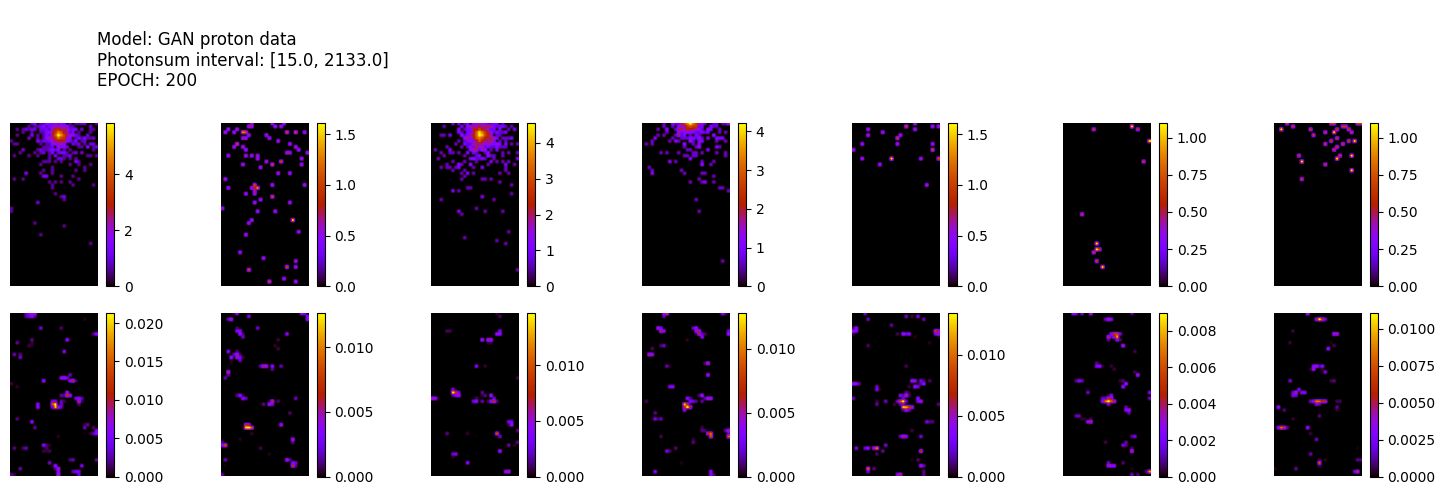

In [37]:
history = train(dataset_with_cond, EPOCHS)